In [1]:
import dataset
import datetime
from datetime import timedelta
from parser import get_parser
import numpy as np 
import pandas as pd 
import torch
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt 
from utils import *
from pygData_util import *
import seaborn as sns
from utils import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from scipy.stats import pearsonr

In [2]:
sns.set_style("whitegrid")

In [4]:
data = dataset.Ndata(path='../../Custom-Semi-Supervised/data/ndata.csv')
parser = get_parser()
args = parser.parse_args(args=
                         ["--data","real-n", 
                          "--sampling","xgb",
                          "--train_from","20140101",
                          "--test_from","20170101",
                          "--test_length","365",
                          "--valid_length","90",
                          "--initial_inspection_rate", "5",
                         ])

In [ ]:
# args
seed = args.seed
initial_inspection_rate = args.initial_inspection_rate
inspection_rate_option = args.inspection_plan
train_begin = args.train_from 
test_begin = args.test_from
test_length = args.test_length
valid_length = args.valid_length
chosen_data = args.data
numWeeks = args.numweeks

# Initial dataset split
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Initial dataset split
train_start_day = datetime.date(int(train_begin[:4]), int(train_begin[4:6]), int(train_begin[6:8]))
test_start_day = datetime.date(int(test_begin[:4]), int(test_begin[4:6]), int(test_begin[6:8]))
test_length = timedelta(days=test_length)    
test_end_day = test_start_day + test_length
valid_length = timedelta(days=valid_length)
valid_start_day = test_start_day - valid_length

# data
data.split(train_start_day, valid_start_day, test_start_day, test_end_day, valid_length, test_length, args)
data.featureEngineering()

In [ ]:
categories=["importer.id","HS6"]
gdata = GraphData(data,use_xgb=False, categories=categories)

In [ ]:
# obtain DATE prediction
DATE_prediction = pd.read_csv("inductive/Ndata_5.0%_prediction.csv").values.ravel()
GNN_prediction = pd.read_csv("inductive/fullmodel_results/GNN_real-n_5.0_prediction.csv").values.ravel()
r, p_value = pearsonr(DATE_prediction,GNN_prediction)
print("Correlation:%.4f" % r)

# overall stats
print("GNN results...")
gnn_result = metrics(GNN_prediction, data.test_cls_label, data.test_reg_label,None)
print("-"*50)
print("DATE results...")
DATE_result = metrics(DATE_prediction, data.test_cls_label, data.test_reg_label,None)

### Average unseen category 
In the following cell, I calculate the ratio of unseen importer/hs in test data.<br>
* Although there are lots of new importers, they only account for a small protion.
* However, in N data, the unseen importer took a large protion in test data.

Since DATE learns **unique embeddings** for importer/hs, we should expect **DATE perform well when the unseen rate is low.**

In [ ]:
print("[valid] Unseen importer rate: %.4f" % (1 - gdata.valid_user.nonzero().shape[0] / data.valid.shape[0]))
print("[Valid] Unseen HS code rate: %.4f" % (1 - gdata.valid_item.nonzero().shape[0] / data.valid.shape[0]))
print("[test] Unseen importer rate: %.4f" % (1 - gdata.test_user.nonzero().shape[0] / data.test.shape[0]))
print("[test] Unseen HS code rate: %.4f" % (1 - gdata.test_item.nonzero().shape[0] / data.test.shape[0]))

## Prediction Analysis
Here I would like to present some analysis of predictions made by DATE and GNN model.<br>
The flow of analysis is presented as follows:
1. Overall evaluation result. (just for reference to let you know which is performing better)
2. Correlation of predictions on illicit transaction.
3. Evaluating precision/recall in different subgroups.
4. Comparing the distribution in different subgroups.

### Importer Analysis
Calculate the frequency of importers appraning in the training set.<br>
Note that interval **\[0,1)** denotes the new importer, i.e. the frequency appearing in training set is 0. <br>
* In the **top-right figure**, the majority of transactions are maed by importers that lies in subgroup [10,50).
* The **bottom-right figure** shows that the new importers have the highest illicit rate, but the # transactions of new importers is small. <br>
Therefore, having a high illicit rate might not be help for overall prediction.

===============Evaluating subgroup:[0.0, 1.0)===============
GNN Results...
Checking top 1% suspicious transactions: 1359
Precision: 0.5386, Recall: 0.1963, Revenue: 0.2236
Checking top 2% suspicious transactions: 2717
Precision: 0.3566, Recall: 0.2599, Revenue: 0.2763
Checking top 5% suspicious transactions: 6792
Precision: 0.2055, Recall: 0.3744, Revenue: 0.3846
Checking top 10% suspicious transactions: 13584
Precision: 0.1357, Recall: 0.4942, Revenue: 0.4763
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 1359
Precision: 0.0655, Recall: 0.0239, Revenue: 0.0482
Checking top 2% suspicious transactions: 2717
Precision: 0.0548, Recall: 0.0400, Revenue: 0.0717
Checking top 5% suspicious transactions: 6791
Precision: 0.0549, Recall: 0.1000, Revenue: 0.1580
Checking top 10% suspicious transactions: 13581
Precision: 0.0636, Recall: 0.2317, Revenue: 0.3264


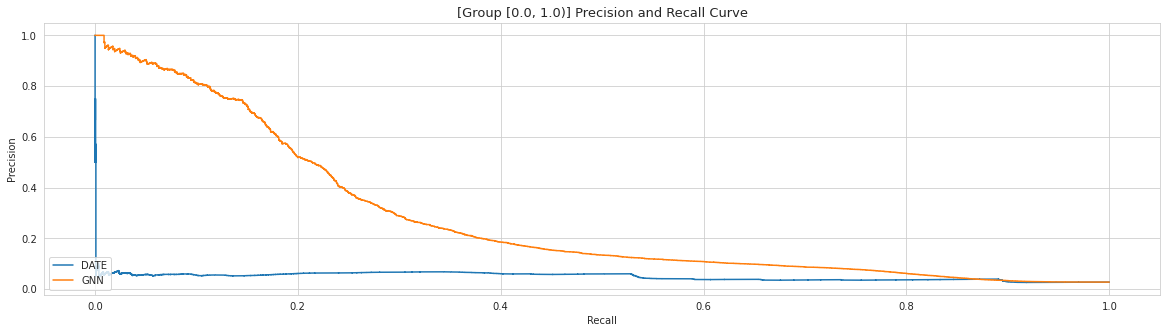

===============Evaluating subgroup:[1.0, 10.0)===============
GNN Results...
Checking top 1% suspicious transactions: 866
Precision: 0.3245, Recall: 0.1279, Revenue: 0.0794
Checking top 2% suspicious transactions: 1731
Precision: 0.2224, Recall: 0.1752, Revenue: 0.1017
Checking top 5% suspicious transactions: 4326
Precision: 0.1466, Recall: 0.2886, Revenue: 0.1987
Checking top 10% suspicious transactions: 8652
Precision: 0.1004, Recall: 0.3955, Revenue: 0.3099
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 864
Precision: 0.2442, Recall: 0.0960, Revenue: 0.0588
Checking top 2% suspicious transactions: 1729
Precision: 0.1440, Recall: 0.1133, Revenue: 0.0897
Checking top 5% suspicious transactions: 4326
Precision: 0.0774, Recall: 0.1525, Revenue: 0.1395
Checking top 10% suspicious transactions: 8646
Precision: 0.0553, Recall: 0.2176, Revenue: 0.2279


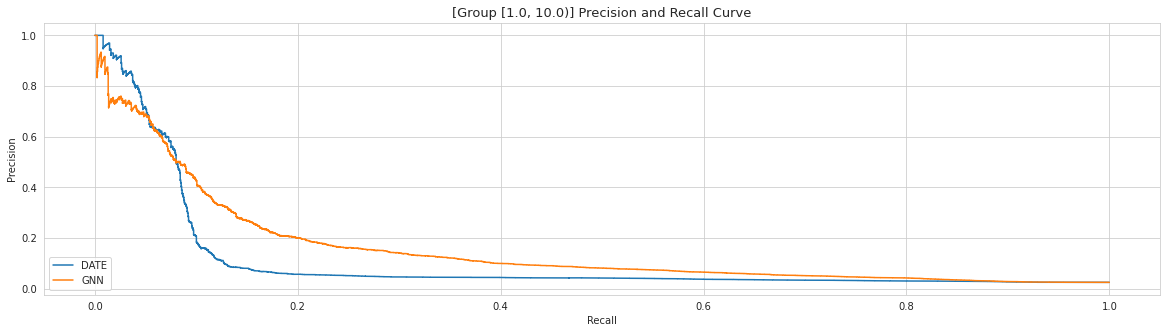

===============Evaluating subgroup:[10.0, 50.0)===============
GNN Results...
Checking top 1% suspicious transactions: 402
Precision: 0.3358, Recall: 0.2049, Revenue: 0.2619
Checking top 2% suspicious transactions: 803
Precision: 0.2080, Recall: 0.2534, Revenue: 0.3032
Checking top 5% suspicious transactions: 2006
Precision: 0.1077, Recall: 0.3278, Revenue: 0.3642
Checking top 10% suspicious transactions: 4010
Precision: 0.0698, Recall: 0.4249, Revenue: 0.4882
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 402
Precision: 0.3085, Recall: 0.1882, Revenue: 0.2582
Checking top 2% suspicious transactions: 803
Precision: 0.1893, Recall: 0.2307, Revenue: 0.3072
Checking top 5% suspicious transactions: 2005
Precision: 0.0968, Recall: 0.2944, Revenue: 0.3878
Checking top 10% suspicious transactions: 4011
Precision: 0.0583, Recall: 0.3551, Revenue: 0.4458


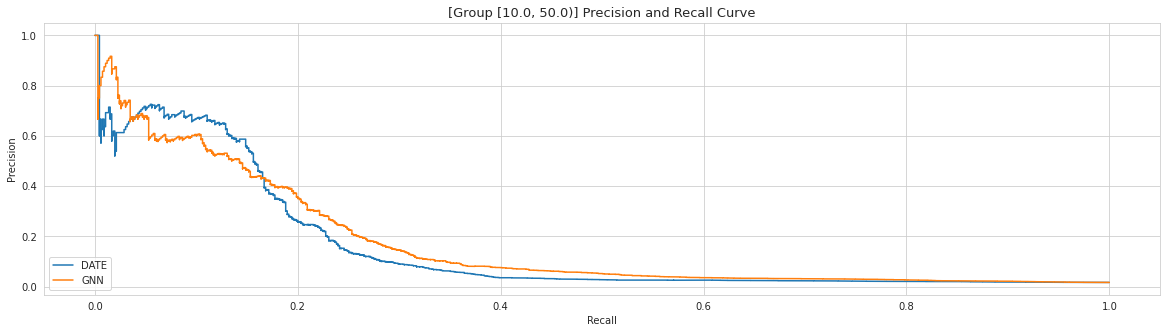

===============Evaluating subgroup:[50.0, 100.0)===============
GNN Results...
Checking top 1% suspicious transactions: 83
Precision: 0.1928, Recall: 0.1290, Revenue: 0.1225
Checking top 2% suspicious transactions: 166
Precision: 0.1205, Recall: 0.1613, Revenue: 0.1508
Checking top 5% suspicious transactions: 412
Precision: 0.0947, Recall: 0.3145, Revenue: 0.3225
Checking top 10% suspicious transactions: 826
Precision: 0.0666, Recall: 0.4435, Revenue: 0.4947
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 83
Precision: 0.1807, Recall: 0.1210, Revenue: 0.1347
Checking top 2% suspicious transactions: 166
Precision: 0.1145, Recall: 0.1532, Revenue: 0.1687
Checking top 5% suspicious transactions: 413
Precision: 0.0896, Recall: 0.2984, Revenue: 0.3723
Checking top 10% suspicious transactions: 826
Precision: 0.0702, Recall: 0.4677, Revenue: 0.5956


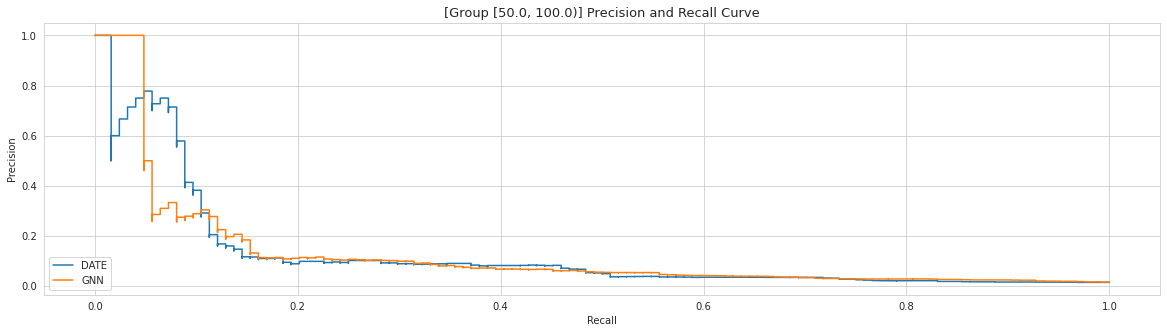

===============Evaluating subgroup:[100.0, 200.0)===============
GNN Results...
Checking top 1% suspicious transactions: 40
Precision: 0.0750, Recall: 0.0341, Revenue: 0.1390
Checking top 2% suspicious transactions: 80
Precision: 0.0750, Recall: 0.0682, Revenue: 0.2419
Checking top 5% suspicious transactions: 198
Precision: 0.0505, Recall: 0.1136, Revenue: 0.2488
Checking top 10% suspicious transactions: 396
Precision: 0.0404, Recall: 0.1818, Revenue: 0.3349
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 40
Precision: 0.0250, Recall: 0.0114, Revenue: 0.0000
Checking top 2% suspicious transactions: 80
Precision: 0.0375, Recall: 0.0341, Revenue: 0.0703
Checking top 5% suspicious transactions: 198
Precision: 0.0606, Recall: 0.1364, Revenue: 0.2222
Checking top 10% suspicious transactions: 395
Precision: 0.0430, Recall: 0.1932, Revenue: 0.3632


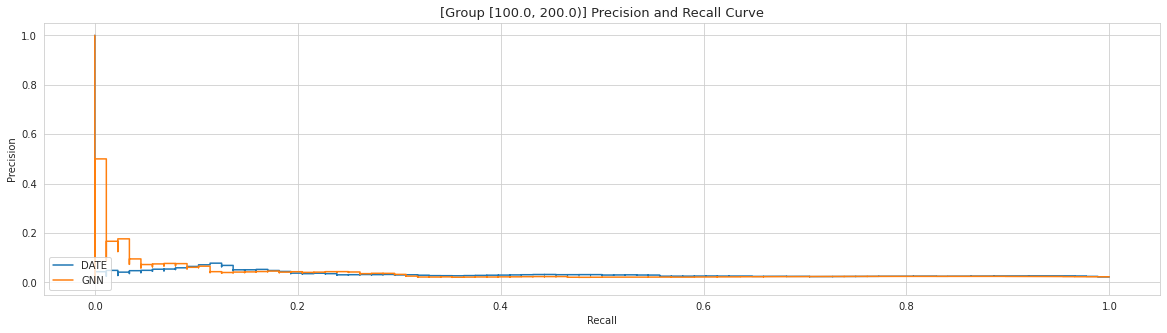

===============Evaluating subgroup:[200.0, 500.0)===============
GNN Results...
===============Evaluating subgroup:[500.0, inf)===============
GNN Results...


In [12]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_user.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_user.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_user.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax1)
# plt.title("[Train] Frequency of importer appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)

# plot 
# ax2 = fig.add_subplot(1,2,2)
# cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax2)
# plt.title("[Test] Frequency of importer appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

#--------- plots for analysis-----------------
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# plt.xticks(rotation=30)
# train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# train_summary.plot(kind="bar",ax=ax1)
# plt.title("[Train] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# ax2 = fig.add_subplot(1,2,2)
# test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# test_summary.plot(kind="bar",ax=ax2)
# plt.title("[Test] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

# ----------prediction analysis--------------
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
for groupID, subgroup in analysis.groupby("bins"):
    try:
        print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
        # metrics
        print("GNN Results...")
        metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
        print("-"*40)
        print("DATE Results...")
        metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    except:
        continue
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()

### HS code Analysis

===============Evaluating subgroup:[0.0, 1.0)===============
GNN Results...
Checking top 1% suspicious transactions: 101
Precision: 0.4554, Recall: 0.1053, Revenue: 0.1256
Checking top 2% suspicious transactions: 201
Precision: 0.2736, Recall: 0.1259, Revenue: 0.1546
Checking top 5% suspicious transactions: 501
Precision: 0.1577, Recall: 0.1808, Revenue: 0.1889
Checking top 10% suspicious transactions: 1001
Precision: 0.1159, Recall: 0.2654, Revenue: 0.2850
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 101
Precision: 0.2772, Recall: 0.0641, Revenue: 0.1002
Checking top 2% suspicious transactions: 201
Precision: 0.1841, Recall: 0.0847, Revenue: 0.1401
Checking top 5% suspicious transactions: 501
Precision: 0.0978, Recall: 0.1121, Revenue: 0.1960
Checking top 10% suspicious transactions: 1001
Precision: 0.0689, Recall: 0.1579, Revenue: 0.2357


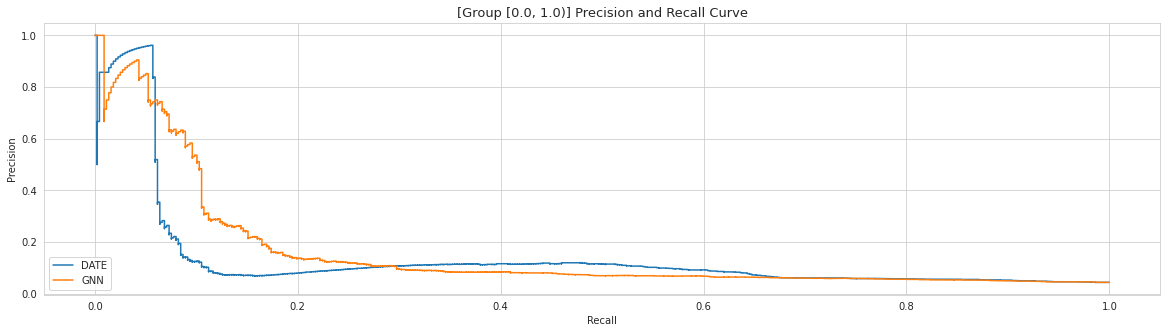

===============Evaluating subgroup:[1.0, 10.0)===============
GNN Results...
Checking top 1% suspicious transactions: 390
Precision: 0.3436, Recall: 0.0848, Revenue: 0.0953
Checking top 2% suspicious transactions: 780
Precision: 0.2359, Recall: 0.1165, Revenue: 0.1364
Checking top 5% suspicious transactions: 1950
Precision: 0.1400, Recall: 0.1728, Revenue: 0.2123
Checking top 10% suspicious transactions: 3899
Precision: 0.0972, Recall: 0.2399, Revenue: 0.2737
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 390
Precision: 0.2744, Recall: 0.0677, Revenue: 0.0842
Checking top 2% suspicious transactions: 780
Precision: 0.1718, Recall: 0.0848, Revenue: 0.1273
Checking top 5% suspicious transactions: 1950
Precision: 0.0964, Recall: 0.1190, Revenue: 0.1842
Checking top 10% suspicious transactions: 3899
Precision: 0.0654, Recall: 0.1614, Revenue: 0.2562


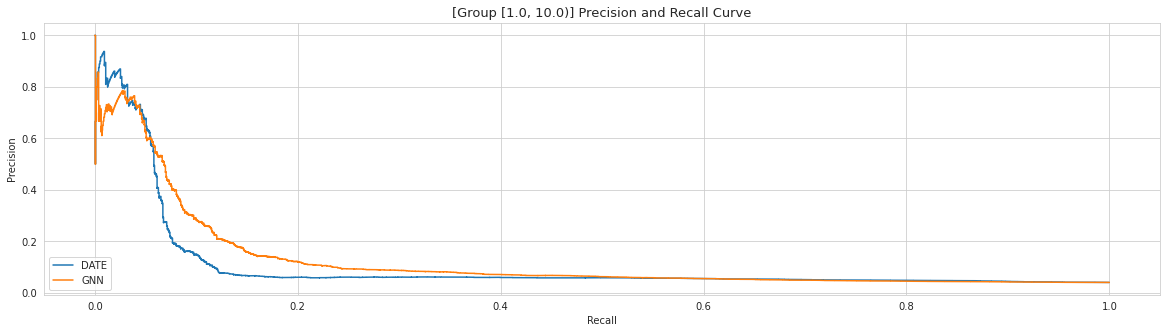

===============Evaluating subgroup:[10.0, 50.0)===============
GNN Results...
Checking top 1% suspicious transactions: 556
Precision: 0.2662, Recall: 0.0788, Revenue: 0.1171
Checking top 2% suspicious transactions: 1112
Precision: 0.1745, Recall: 0.1034, Revenue: 0.1304
Checking top 5% suspicious transactions: 2778
Precision: 0.1098, Recall: 0.1625, Revenue: 0.1980
Checking top 10% suspicious transactions: 5556
Precision: 0.0842, Recall: 0.2493, Revenue: 0.2984
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 556
Precision: 0.2248, Recall: 0.0666, Revenue: 0.0802
Checking top 2% suspicious transactions: 1112
Precision: 0.1358, Recall: 0.0804, Revenue: 0.1154
Checking top 5% suspicious transactions: 2778
Precision: 0.0720, Recall: 0.1066, Revenue: 0.2042
Checking top 10% suspicious transactions: 5556
Precision: 0.0542, Recall: 0.1604, Revenue: 0.2676


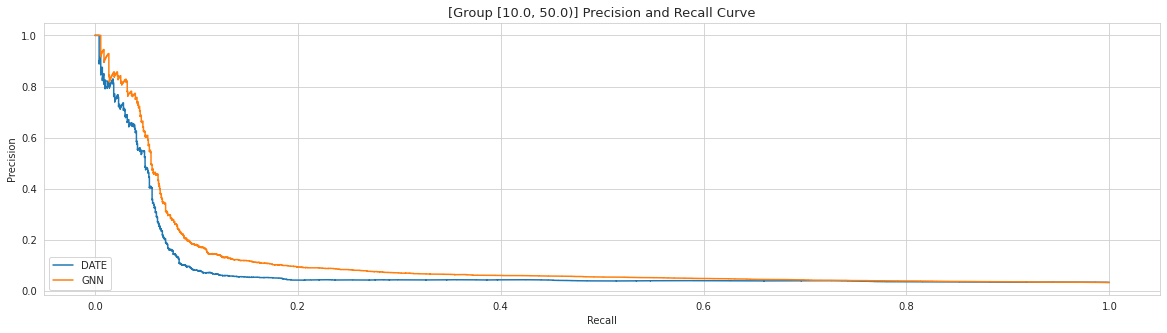

===============Evaluating subgroup:[50.0, 100.0)===============
GNN Results...
Checking top 1% suspicious transactions: 144
Precision: 0.3194, Recall: 0.1165, Revenue: 0.1920
Checking top 2% suspicious transactions: 286
Precision: 0.2098, Recall: 0.1519, Revenue: 0.2141
Checking top 5% suspicious transactions: 717
Precision: 0.1004, Recall: 0.1823, Revenue: 0.2305
Checking top 10% suspicious transactions: 1433
Precision: 0.0649, Recall: 0.2354, Revenue: 0.2565
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 144
Precision: 0.2708, Recall: 0.0987, Revenue: 0.1866
Checking top 2% suspicious transactions: 287
Precision: 0.1463, Recall: 0.1063, Revenue: 0.1883
Checking top 5% suspicious transactions: 717
Precision: 0.0739, Recall: 0.1342, Revenue: 0.1987
Checking top 10% suspicious transactions: 1433
Precision: 0.0482, Recall: 0.1747, Revenue: 0.2289


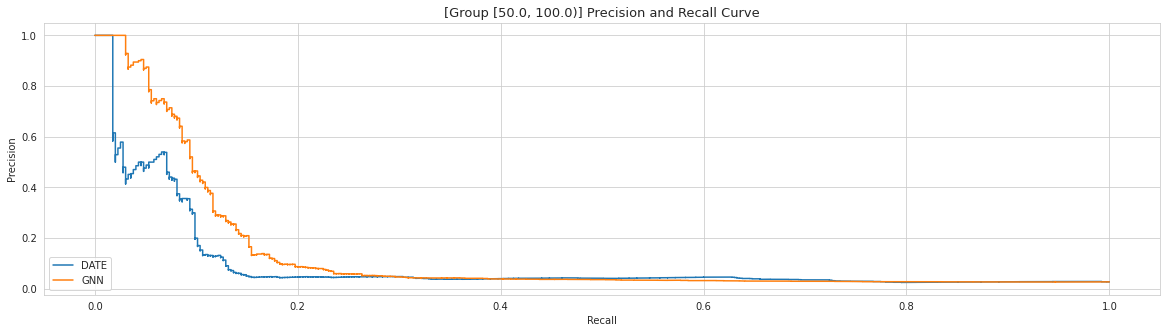

===============Evaluating subgroup:[100.0, 200.0)===============
GNN Results...
Checking top 1% suspicious transactions: 237
Precision: 0.1899, Recall: 0.0660, Revenue: 0.0564
Checking top 2% suspicious transactions: 474
Precision: 0.1899, Recall: 0.1320, Revenue: 0.1038
Checking top 5% suspicious transactions: 1184
Precision: 0.1216, Recall: 0.2111, Revenue: 0.1769
Checking top 10% suspicious transactions: 2367
Precision: 0.0955, Recall: 0.3314, Revenue: 0.2787
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 237
Precision: 0.1772, Recall: 0.0616, Revenue: 0.0624
Checking top 2% suspicious transactions: 474
Precision: 0.1055, Recall: 0.0733, Revenue: 0.0852
Checking top 5% suspicious transactions: 1184
Precision: 0.0659, Recall: 0.1144, Revenue: 0.1281
Checking top 10% suspicious transactions: 2367
Precision: 0.0499, Recall: 0.1730, Revenue: 0.1753


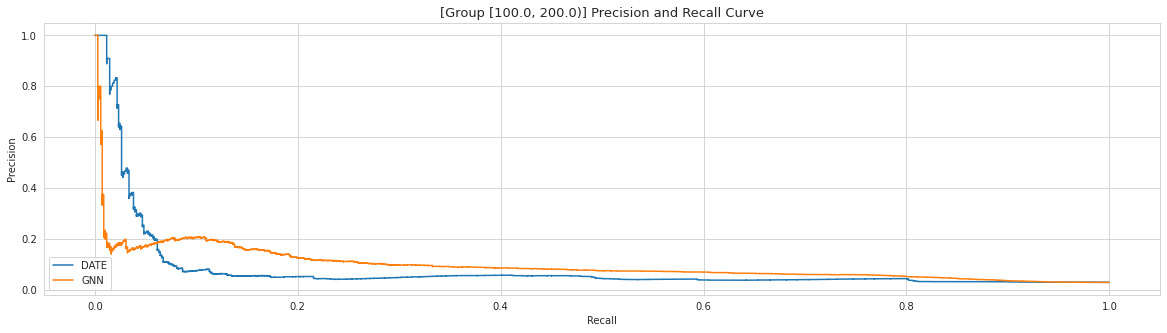

===============Evaluating subgroup:[200.0, 500.0)===============
GNN Results...
Checking top 1% suspicious transactions: 592
Precision: 0.3682, Recall: 0.2332, Revenue: 0.2935
Checking top 2% suspicious transactions: 1183
Precision: 0.2502, Recall: 0.3166, Revenue: 0.3755
Checking top 5% suspicious transactions: 2957
Precision: 0.1491, Recall: 0.4717, Revenue: 0.5095
Checking top 10% suspicious transactions: 5913
Precision: 0.0964, Recall: 0.6096, Revenue: 0.6065
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 585
Precision: 0.0444, Recall: 0.0278, Revenue: 0.0396
Checking top 2% suspicious transactions: 1182
Precision: 0.0271, Recall: 0.0342, Revenue: 0.0581
Checking top 5% suspicious transactions: 2957
Precision: 0.0179, Recall: 0.0567, Revenue: 0.0813
Checking top 10% suspicious transactions: 5913
Precision: 0.0423, Recall: 0.2674, Revenue: 0.3810


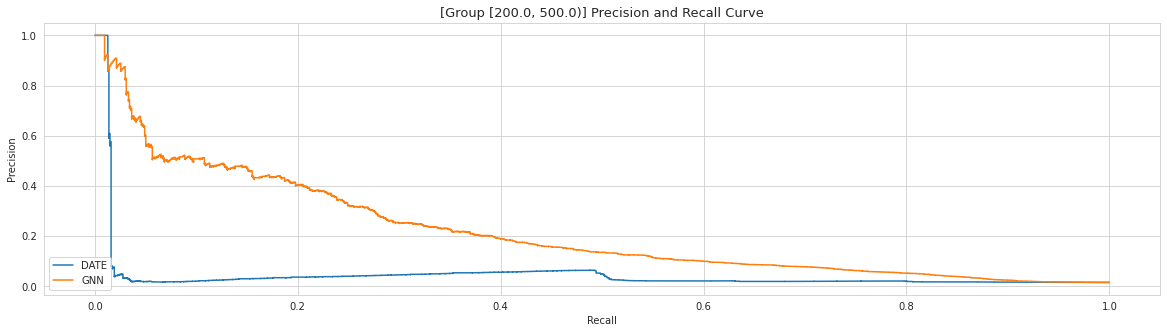

===============Evaluating subgroup:[500.0, inf)===============
GNN Results...
Checking top 1% suspicious transactions: 729
Precision: 0.3594, Recall: 0.2941, Revenue: 0.4911
Checking top 2% suspicious transactions: 1463
Precision: 0.2638, Recall: 0.4332, Revenue: 0.6341
Checking top 5% suspicious transactions: 3658
Precision: 0.1632, Recall: 0.6700, Revenue: 0.8099
Checking top 10% suspicious transactions: 7315
Precision: 0.0965, Recall: 0.7924, Revenue: 0.9100
----------------------------------------
DATE Results...
Checking top 1% suspicious transactions: 732
Precision: 0.0328, Recall: 0.0269, Revenue: 0.0159
Checking top 2% suspicious transactions: 1463
Precision: 0.0314, Recall: 0.0516, Revenue: 0.0210
Checking top 5% suspicious transactions: 3658
Precision: 0.0189, Recall: 0.0774, Revenue: 0.0390
Checking top 10% suspicious transactions: 7315
Precision: 0.0838, Recall: 0.6880, Revenue: 0.7077


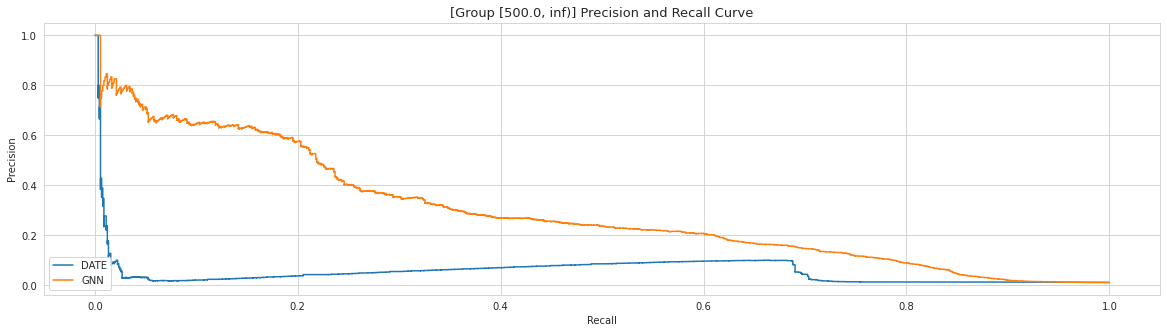

In [10]:
# calculate the frequency of importer of test transaction appearing in training set
cnter = Counter(gdata.train_item.numpy())
test_counts = [cnter.get(i,0) for i in gdata.test_item.numpy()]
count_Ser = pd.Series(test_counts)
train_counts = [cnter.get(i,0) for i in gdata.train_item.numpy()]
train_Ser = pd.Series(train_counts)

# plot training data for reference
bins = [0, 1,10,50,100,200,500,np.inf]
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# cuteted_bin = pd.cut(train_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax1)
# plt.title("[Train] Frequency of HSCode appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)

# # plot 
# ax2 = fig.add_subplot(1,2,2)
# cuteted_bin = pd.cut(count_Ser,bins, include_lowest=True, right=False).value_counts()
# cuteted_bin.plot(kind="bar",ax=ax2)
# plt.title("[Test] Frequency of HSCode appearing in the training set")
# plt.ylabel("# transaction")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

### illicit rate among different subgroup ###

# train
train_bins = pd.cut(train_Ser,bins, include_lowest=True, right=False)
train_label = pd.Series(data.train_cls_label)
train_summary = pd.concat([train_bins,train_label],axis=1)
train_summary.columns = ["bin","illicit"]

# test
test_bins = pd.cut(count_Ser,bins, include_lowest=True, right=False)
test_label = pd.Series(data.test_cls_label)
test_summary = pd.concat([test_bins,test_label],axis=1)
test_summary.columns = ["bin","illicit"]

# ----------plots for analysis--------------
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1,2,1)
# plt.xticks(rotation=30)
# train_summary = train_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# train_summary.plot(kind="bar",ax=ax1)
# plt.title("[Train] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# ax2 = fig.add_subplot(1,2,2)
# test_summary = test_summary.groupby("bin").mean().sort_values("illicit",ascending=False)
# test_summary.plot(kind="bar",ax=ax2)
# plt.title("[Test] Illicit rate among different subgroup")
# plt.ylabel("illicit rate")
# plt.xlabel("Frequency in training set")
# plt.xticks(rotation=30)
# plt.show()

# ----------prediction analysis--------------
analysis = pd.DataFrame({"bins":test_bins.values, \
                             "gnn":GNN_prediction, "DATE":DATE_prediction, \
                             "cls_label":data.test_cls_label, "rev_label": data.test_reg_label})
for groupID, subgroup in analysis.groupby("bins"):
    print("="*15+"Evaluating subgroup:%s" % groupID + "="*15)
    # metrics
    print("GNN Results...")
    metrics(subgroup["gnn"],subgroup["cls_label"],subgroup["rev_label"],None)
    print("-"*40)
    print("DATE Results...")
    metrics(subgroup["DATE"],subgroup["cls_label"],subgroup["rev_label"],None)
    # plots
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["DATE"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "DATE",ax=ax)
    precision, recall, _ = precision_recall_curve(subgroup["cls_label"], subgroup["gnn"],pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name = "GNN",ax=ax)
    plt.title("[Group %s] Precision and Recall Curve" % groupID, fontsize=13)
    plt.show()